# Preparation

### MROB: Mobile Robotics library
The Skoltech Mobile Robotics library (mrob) is our common framework for implementing our robotics research and projects. It includes a core set of functionalities including perception, path planning and optimization. The present library is meant to be a self-contained library.

- common: common matrix definitions and typedefs.
- **SE3: Rigid Body Transformations library.**
- Fgraph: Factor Graph (WIP)
- PCReg: Point Cloud Registration (WIP)
- mrobPy Python bindings (using pybind11) for some of the above methods.

#### SE3 


 - **Constructors**:
    - Mat61,requires the Transformation in Se3
    - Mat4, requires the Transformation matrix 4x4, Lie algebra xi^ \in se3 representing the rigid body transformation around the identity, by default generates T = exp(0^) = I
    - SE3, allows to construct from Eigen expressions

  *Returns True is the matrix is a valid transformation and False if not*
 - **T()**, 4x4 Transformation matrix
 - **R()**, returns a matrix 3x3 of the SO3 rotation corresponding to the subblock matrix
 - **t()**, returns translation vector
 - **mul()**, multiplication function
 - **update_lhs()**, updates the current transformation incrementaly
 - **update_rhs()**,  exponential mapping of a skew symetric matrix in se3.
 - **ln()**, logarithm map, first we calculate ln(R) and then 
 
 V^-1 = I - 1/2 w^ + 1/o^2(1 - A / 2B) (w^)^2, $v = V^-1 t$ 

 Returns the vector $xi \in R^6$ which corresponds to the Lie algebra SE3
 - **transform()**, transforms a point $p = (x,y,z)'$ such as $res = T*p$. This function saves to transform to homogeneous coordinates.
 - **transform_array()**, transforms an array of points $P = {p_n} = (x,y,z)'_n$ such as $res = T*p_n$. The array is of the form $3xN$. This function saves to transform to homogeneous coordinates.
 - **inv()**, inverse: 
 $$
 T^-1 = \begin{vmatrix}
R'&-R't\\
0&1\\
\end{vmatrix}
$$
 - **adj()**, Adjoint: T Exp(x) = Exp ( Adj_T x) T
  $$
Adj_T  = \begin{vmatrix}
R & 0\\
t^R&R\\
\end{vmatrix}
$$
 - **distance()**,provide the distance as a norm on the tangent space of the $ln(T * T_{rhs}^{-1}) $
 - **print()**

### Download not compiled version of MROB libraray (mrob.zip) and unzip it

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='16sBf2VtnnlUnIPgqoKpR_rN8WTU88uSA',
                                    dest_path='./mrob.zip',
                                    unzip=True)

### Install dependencies and compile the library


In [2]:
!sudo apt install build-essential cmake python3-distutils python3-dev libeigen3-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
libeigen3-dev is already the newest version (3.3.4-4).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
python3-dev is already the newest version (3.6.7-1~18.04).
python3-distutils is already the newest version (3.6.9-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [3]:
!cd mrob && mkdir build && cd build && cmake .. && make -j

mkdir: cannot create directory ‘build’: File exists


### Check if everything exists

In [4]:
!ls -l 'mrob/lib'

total 800
-rwxr-xr-x 1 root root  13880 Mar 22 10:25 libcommon.so
-rwxr-xr-x 1 root root  51640 Mar 22 10:26 libEigenFactors.so
-rwxr-xr-x 1 root root 203344 Mar 22 10:26 libFGraph.so
-rwxr-xr-x 1 root root 207704 Mar 22 10:26 libPCRegistration.so
-rwxr-xr-x 1 root root  65496 Mar 22 10:25 libSE3.so
-rwxr-xr-x 1 root root 269952 Mar 22 10:26 mrob.cpython-36m-x86_64-linux-gnu.so


### Import libraries

In [0]:
path = 'mrob/lib'
import sys
sys.path.append(path)
import mrob

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])


# Data import

In [0]:
points_dict_hw = load_obj('data')
X_hw = points_dict_hw['X']
Y_hw = points_dict_hw['Y']
S_hw = points_dict_hw['S']

# Task1
### A.
Create a function that plots the PC Y and the transformed PC T · X. Also plot a segment between
each pair of points. Show a plot for the initial transformation estimation T [0] = I.


In [0]:
def PC_plot(Y, X, T, label_add=''):
  Y = Y.T
  T_X = T.transform_array(X.T)

  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.scatter3D(Y[0], Y[1], Y[2], c='tab:orange', label='Y')
  ax.scatter3D(T_X[0], T_X[1], T_X[2], c='tab:blue', label='T · X')
  for i in range(len(Y[0])):
    ax.plot([Y[0][i], T_X[0][i]], [Y[1][i], T_X[1][i]], [Y[2][i], T_X[2][i]], c='tab:green')
  ax.legend()
  ax.set_title('PC ' + label_add)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  plt.show()

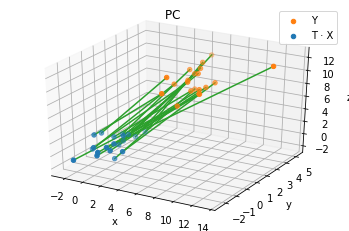

In [8]:
T_0 = mrob.SE3(np.zeros(6))
PC_plot(Y_hw, X_hw, T_0)


### B.
Create a function that outputs the current value of C(T ), that is, the alignment error.

In [0]:
def C_T(Y, X, T, S):
  R = T.transform_array(X.T) - Y.T
  c_t = 0
  for i in range(len(R[0,:])):
    c_t += (R[:,i] @ np.linalg.inv(S[i]) @ R[:,i][np.newaxis].T)[0]
  c_t = c_t / 2
  return(c_t)

### C.
Create a function that calculates the gradient

In [0]:
def grad(Y, X, T, S):
  gradient = np.zeros(6)
  R = T.transform_array(X.T) - Y.T
  for i in range(len(X)):
    r_i = R[:, i]
    rot = skew(T.transform(X[i]))
    grad_i = np.hstack((-rot , np.eye(3)))
    gradient = gradient + r_i @ np.linalg.inv(S[i]) @ grad_i
  return gradient

### D.
Create a function that updates the current value of the transformation given the gradient just
calculated. For that, we will use Gradient Descent with update sizes of α = 10 −6 [0.1, 0.1, 0.1, 1, 1, 1]. To test
this function, provide the initial condition T [0] = I and calculate the error before and after the update. You
can also plot the point clouds before and after.

In [0]:
def update_T(Y, X, T, S, coef=1):
  gradient = grad(Y, X, T, S)
  alpha = coef*0.000001*np.hstack((0.1*np.ones(3),np.ones(3)))
  T.update_lhs(- alpha * gradient)
  return T

A test:

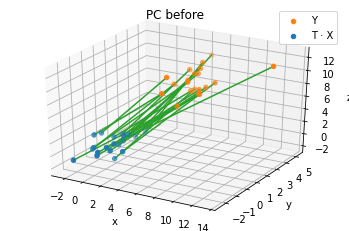

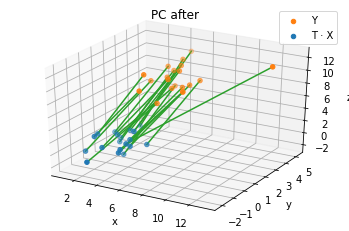

In [12]:
T = mrob.SE3(np.zeros(6))
PC_plot(Y_hw, X_hw, T, 'before')
T = update_T(Y_hw, X_hw, T, S_hw)
PC_plot(Y_hw, X_hw, T, 'after')





### E.
Optimize the function C(T ) until convergence. For that, we will define a convergence criterion to
be the difference in errors < 1e − 4. Plot the results of the error w.r.t. the number of iterations. Show also a
plot of the point clouds aligned after convergence. Comment on the results.

The difference in errors: 9.999940864702239e-05
Iteration number: 309385
Last error: 41.24784849485105


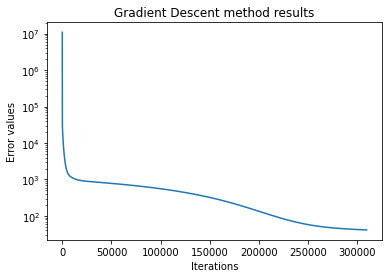

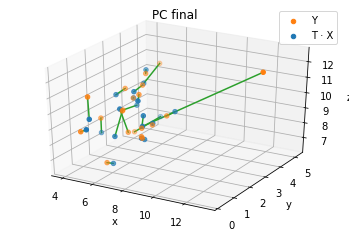

In [13]:
errors = []
T = mrob.SE3(np.zeros(6))
k = 0
prev_error = 0
error = 1
for k in range(1000000):
  prev_error = error
  error = C_T(Y_hw, X_hw, T, S_hw)
  T = update_T(Y_hw, X_hw, T, S_hw, 0.35)
  errors.append(error)
  if abs(error - prev_error) < 0.0001:
    break


print('The difference in errors:', abs(error - prev_error))
print('Iteration number:', k)
plt.semilogy(errors)
plt.xlabel('Iterations')
plt.ylabel('Error values')
plt.title('Gradient Descent method results')

print('Last error:', errors[-1])

PC_plot(Y_hw, X_hw, T, 'final')

### Estimation of RBT

In [14]:
T_ = T.T()

print('Estimated RBT:', T_, sep='\n')

Estimated RBT:
[[ 0.80238919 -0.51635256  0.29925178  6.06585172]
 [ 0.52891208  0.38298668 -0.75734616  2.60887803]
 [ 0.27644819  0.76596426  0.58040948  9.10654042]
 [ 0.          0.          0.          1.        ]]


### True RBT

In [15]:
print('True RBT:', load_obj('T'), sep='\n')

True RBT:
[[ 0.7438831  -0.50134356  0.44191919  6.04302334]
 [ 0.65938053  0.44284877 -0.60753789  2.62663025]
 [ 0.10888184  0.74333008  0.66000389  9.21214559]
 [ 0.          0.          0.          1.        ]]


**Comment on results**:

It was very difficult to chose right values of step sizes. Otherwise, growing oscillations were obtained.

This method needs a lot of steps to be done till convergence.

However, the obtained matrix is close to the true one.

# Task2
### A.
Create a function, based on the previous function from (C), that returns the gradient vector and the
Hessian matrix.

In [0]:
def grad_and_hes(Y, X, T, S):
  gradient = np.zeros(6)
  hessian = np.zeros((6, 6))
  R = T.transform_array(X.T) - Y.T
  for i in range(len(X)):
    r_i = R[:, i]
    rot = skew(T.transform(X[i]))
    grad_i = np.hstack((-rot , np.eye(3)))
    gradient = gradient + r_i @ np.linalg.inv(S[i]) @ grad_i
    hessian = hessian + grad_i.T @ np.linalg.inv(S[i]) @ grad_i
  return gradient, hessian

### B.
Create a function, based on (D) that updates T by using α = 1.

In [0]:
def update_T_GN(Y, X, T, S):
  gradient, hessian = grad_and_hes(Y, X, T, S)
  alpha = np.ones(6)
  T.update_lhs(- alpha * (np.linalg.inv(hessian) @ gradient))
  return T

A test:

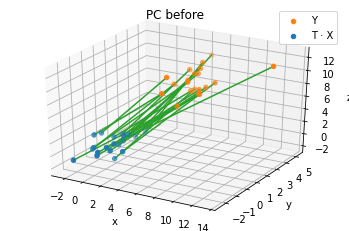

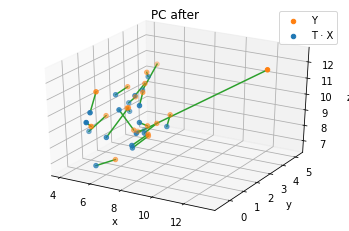

In [18]:
T = mrob.SE3(np.zeros(6))
PC_plot(Y_hw, X_hw, T, 'before')
T = update_T_GN(Y_hw, X_hw, T, S_hw)
PC_plot(Y_hw, X_hw, T, 'after')

### C.
Optimize the function C(T ) until convergence using GN. Plot the error w.r.t. iterations. Comment
on the results and compare with the result obtained in Task 1.

The difference in errors: -1.1964222323967988e-07
Iteration number: 5
Last error 21.96186933307484


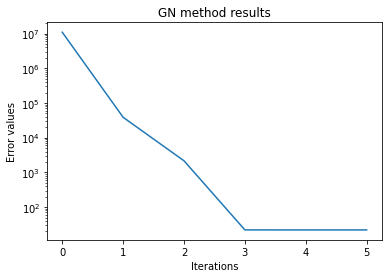

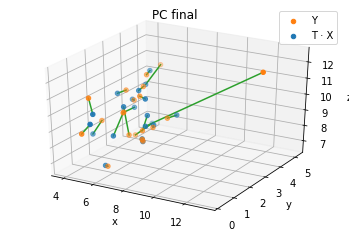

In [19]:
errors = []
T = mrob.SE3(np.zeros(6))
k = 0
error1 = 0
error = 1
for k in range(10000):
  error1 = error
  error = C_T(Y_hw, X_hw, T, S_hw)
  T = update_T_GN(Y_hw, X_hw, T, S_hw)
  errors.append(error)
  if abs(error - error1) < 0.0001:
    break


print('The difference in errors:', error - error1)
print('Iteration number:', k)
plt.semilogy(errors)
plt.xlabel('Iterations')
plt.ylabel('Error values')
plt.title('GN method results')

print('Last error', errors[-1])

PC_plot(Y_hw, X_hw, T, 'final')

**Comment on results:**
Using GN is more profitable in this case than Gradient Descent method.

The main disadvantage of the Gradient Descent method is that its step size needs to be optimal selected. Otherwise, some oscillations can be obtained.

GN method doesn't need to be set. For this task it does just 5 iterations till convergence, whereas Gradient Descent method needs much more. What is more, the last error is less for GN.